In [23]:
import pandas as pd
import quandl
import datetime
import pandas_datareader.data as web


In [65]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2019,1,1)
end = datetime.datetime(2019,12,31)

GLOBANT = web.DataReader("GLOB", "yahoo", start, end)
 
type(GLOBANT)

pandas.core.frame.DataFrame

In [66]:
GLOBANT.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,55.459999,53.830002,55.259998,54.470001,178600,54.470001
2019-01-03,53.935001,50.910000,53.720001,52.099998,411900,52.099998
2019-01-04,54.525002,51.980000,52.119999,53.830002,247500,53.830002
2019-01-07,57.490002,54.279999,54.330002,57.250000,208900,57.250000
2019-01-08,58.560001,56.320000,57.820000,57.389999,131200,57.389999


Populating the interactive namespace from numpy and matplotlib


/Users/pablotempone/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


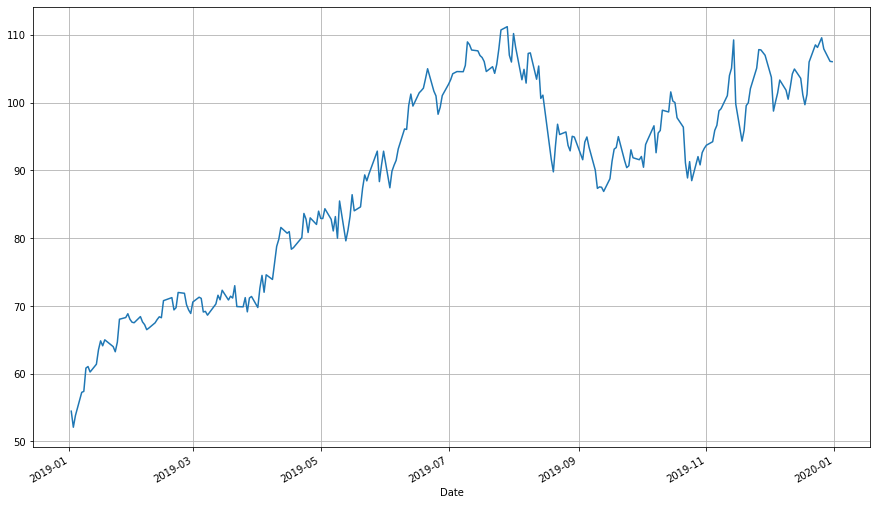

In [67]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
GLOBANT["Adj Close"].plot(grid = True) # Plot the adjusted closing 

## Análisis de apertura y cierre para cada día

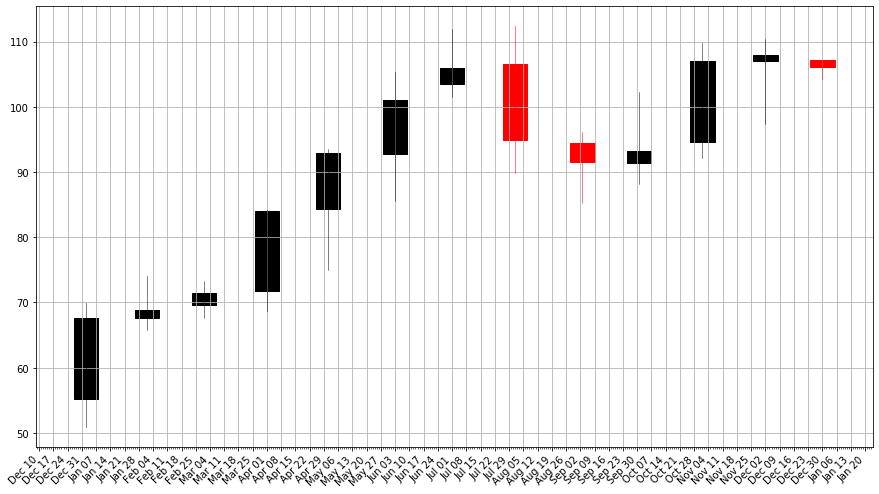

In [68]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = [s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(GLOBANT, adj=True, stick="month")

Las velas negras significan que el cierre fue mayor al de apertura, por lo que hubo ganancia. Las rojas el opuesto.

## Generar los retornos de las acciones

Definimos $r$ como el retorno, entonces la fórmula sería la siguiente:
$r_{t,0}= \frac{precio_{t}}{precio_{0}}$

In [69]:
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"GLOB": GLOBANT["Adj Close"]})
 
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head() - 1

,GLOB
Date,
2019-01-02,0.000000
2019-01-03,-0.043510
2019-01-04,-0.011750
2019-01-07,0.051037
2019-01-08,0.053607


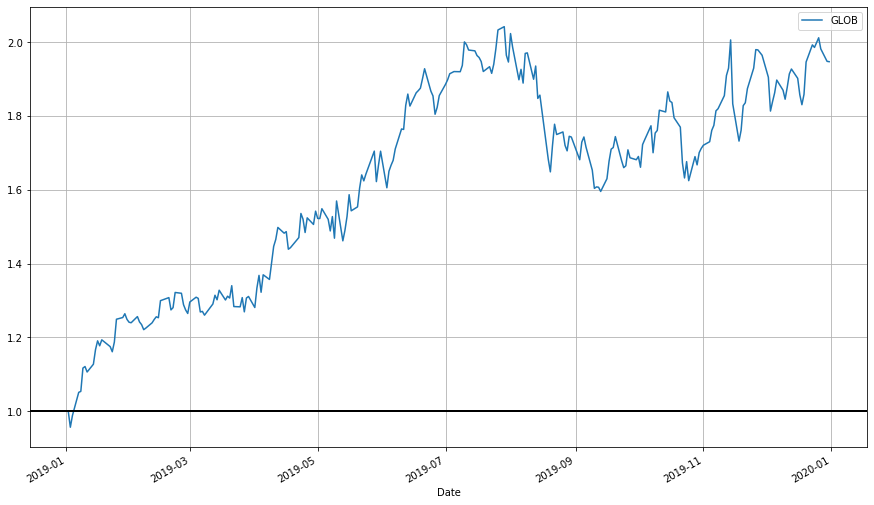

In [70]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

## Crecimiento

$cambio_{t} = log(precio_{t})-log(price{t-1})$

Se utiliza la diferencia de los logartimos, que se interpreta como el porcentaje de los cambios en el precio de un acción, pero que no depende del denominador.
Además la diferencia de logaritmo hacen que la suma de las diferencias se puedan interpretar como el cambio total en porcentaje sobre el periodo sumado.

In [71]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,GLOB
Date,
2019-01-02,NaN
2019-01-03,-0.044485
2019-01-04,0.032666
2019-01-07,0.061597
2019-01-08,0.002442


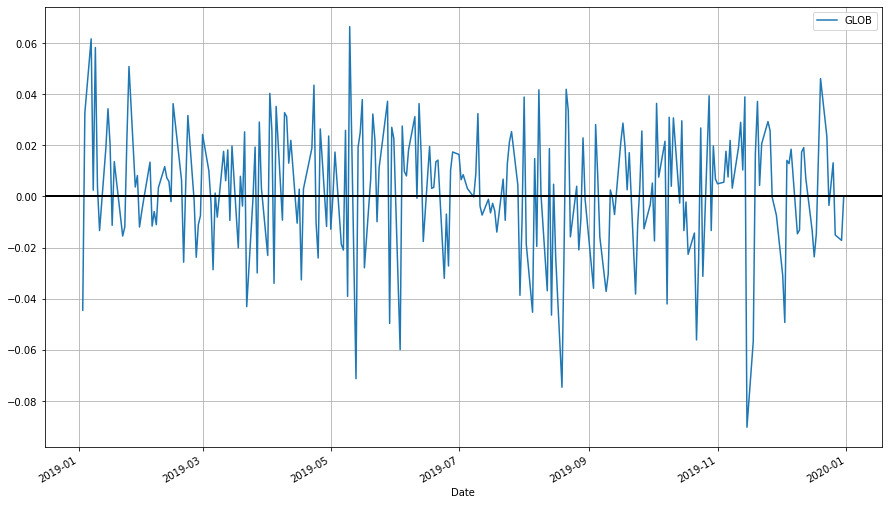

In [72]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

Se compara ahora con el total del mercado, SPY, que es el ticker de SPDR S&P 500 exchange (https://finance.yahoo.com/quote/%5EGSPC?p=^GSPC).

In [73]:
#import pandas_datareader.data as web    # Going to get SPY from Yahoo! (I know I said you shouldn't but I didn't have a choice)
spyder = web.DataReader("SPY", "yahoo", start, end)    # Didn't work
#spyder = web.DataReader("SPY", "google", start, end)    # Didn't work either
# If all else fails, read from a file, obtained from here: http://www.nasdaq.com/symbol/spy/historical
#spyderdat = pd.read_csv("/home/curtis/Downloads/HistoricalQuotes.csv")    # Obviously specific to my system; set to
                                                                          # location on your machine
#spyderdat = pd.DataFrame(spyder.loc[:, ["open", "high", "low", "close", "close"]].iloc[1:].as_matrix(),
#                         index=pd.DatetimeIndex(spyderdat.iloc[1:, 0]),
#                         columns=["Open", "High", "Low", "Close", "Adj Close"]).sort_index()
 
#spyder = spyderdat.loc[start:end]
 
stocks = stocks.join(spyder.loc[:, "Adj Close"]).rename(columns={"Adj Close": "SPY"})
stocks.head()

,GLOB,SPY
Date,,
2019-01-02,54.470001,243.025879
2019-01-03,52.099998,237.226593
2019-01-04,53.830002,245.172668
2019-01-07,57.250000,247.105774
2019-01-08,57.389999,249.427399


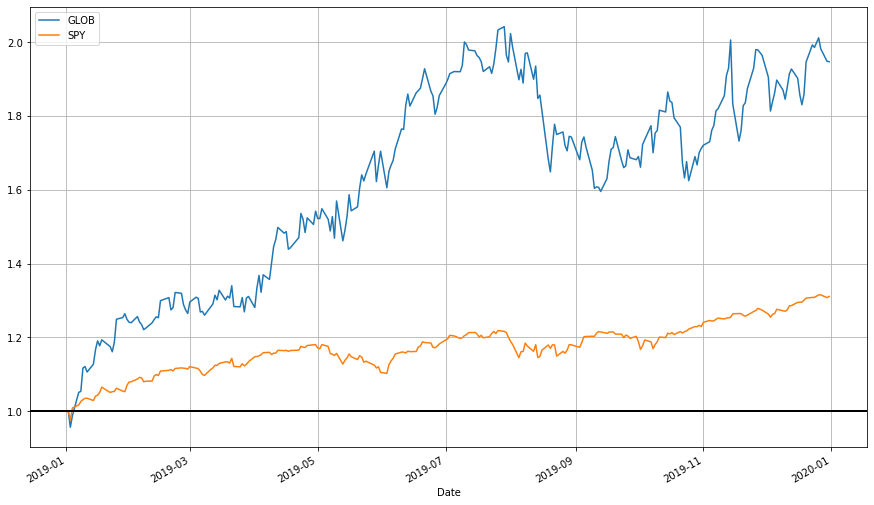

In [74]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

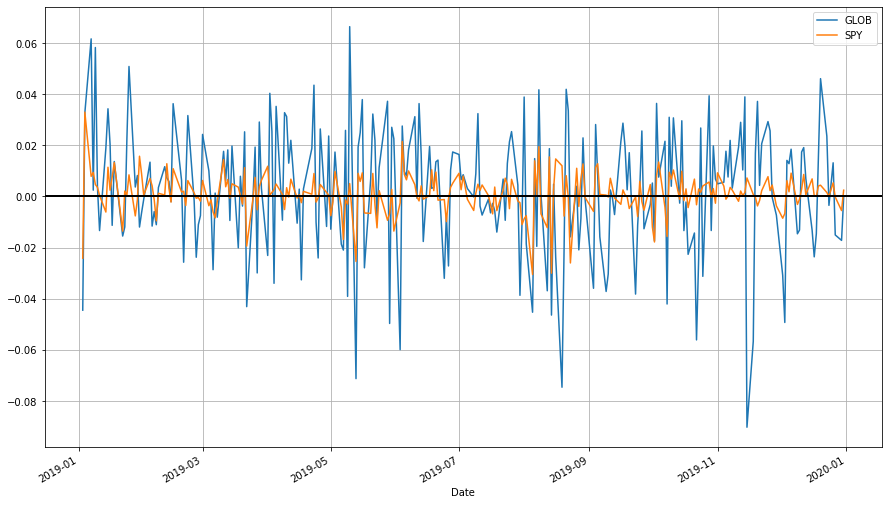

In [75]:
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1)))
stock_change.plot(grid=True).axhline(y = 0, color = "black", lw = 2)


## Métodos clásicos

Anualizar los retornos, calculando el ratio de porcentaje anual (APR).

In [76]:
stock_change_apr = stock_change * 252 * 100    # There are 252 trading days in a year; the 100 converts to percentages
stock_change_apr.tail()

,GLOB,SPY
Date,,
2019-12-24,-88.387858,0.786100
2019-12-26,331.020303,133.789504
2019-12-27,-379.999696,-6.246554
2019-12-30,-433.276416,-139.317668
2019-12-31,-11.877301,61.145852


Tarifa de 0 riesgo $r_{RF}$.

In [77]:
tbill = quandl.get("FRED/TB3MS", start_date=start, end_date=end)
tbill.tail()

,Value
Date,
2019-08-01,1.95
2019-09-01,1.89
2019-10-01,1.65
2019-11-01,1.54
2019-12-01,1.54


In [78]:
rrf = tbill.iloc[-1, 0]    # Get the most recent Treasury Bill rate
rrf

1.54

In [79]:
smcorr = stock_change_apr.drop("SPY", 1).corrwith(stock_change_apr.SPY)    # Since RRF is constant it doesn't change the
                                                                           # correlation so we can ignore it in our
                                                                           # calculation
smcorr

GLOB    0.442932
dtype: float64

computar el alpha y beta

In [80]:
sy = stock_change_apr.drop("SPY", 1).std()
sx = stock_change_apr.SPY.std()
sy

GLOB    623.12226
dtype: float64

In [81]:
sx    # Standard deviation for x

199.28734844114126

In [82]:
ybar = stock_change_apr.drop("SPY", 1).mean() - rrf
xbar = stock_change_apr.SPY.mean() - rrf
ybar

GLOB    65.351502
dtype: float64

In [83]:
xbar

25.637318811699494

In [84]:
beta = smcorr * sy / sx
alpha = ybar - beta * xbar
beta
alpha

GLOB    29.845381
dtype: float64

## Sharpe ratio

$$ Sharpe\quad ratio = \frac{R_{t}-r_{RF}}{s}$$

Sirve para ver si las acciones ganan más que el promedio de las 0 riesgo. Usando el estadístico t. Cuanto más grande es el valor, más probable que ocurra lo primero.

In [85]:
sharpe = (ybar - rrf)/sy
sharpe

GLOB    0.102406
dtype: float64

## Moving averages

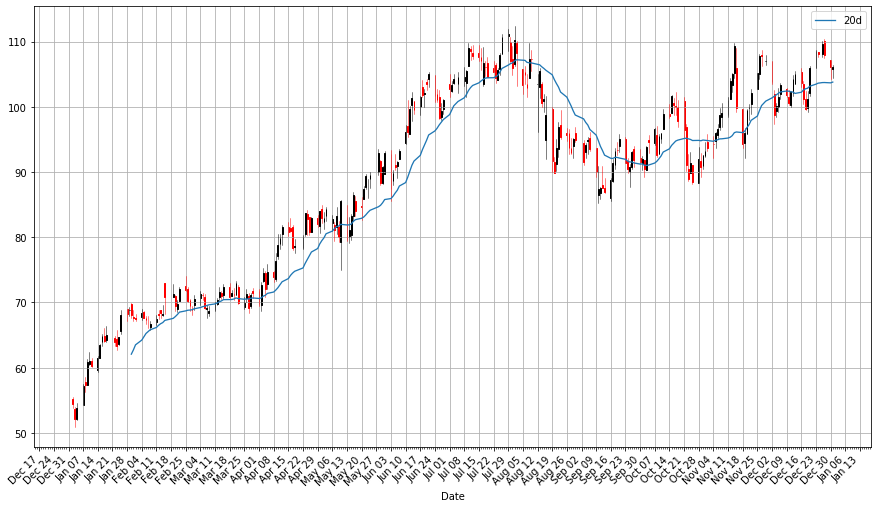

In [86]:
GLOBANT["20d"] = np.round(GLOBANT["Adj Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(GLOBANT.loc['2019-01-01':'2019-12-31',:], otherseries = "20d", adj=True)

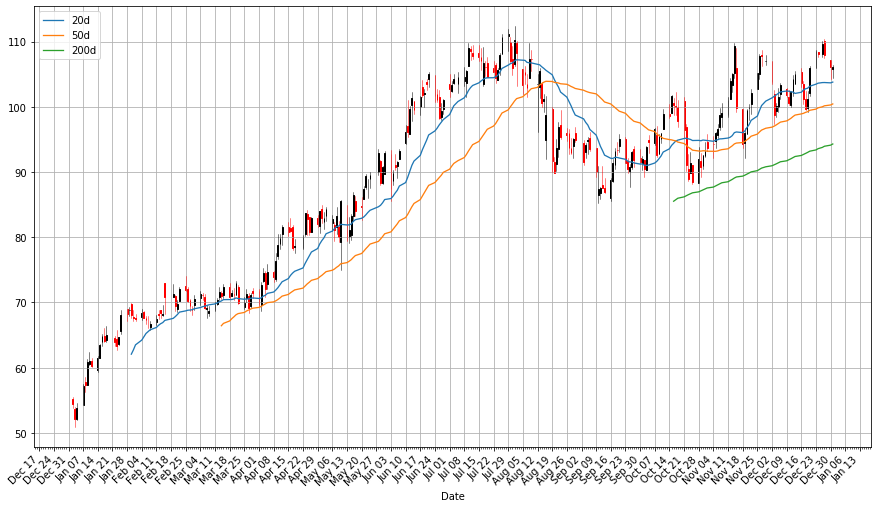

In [87]:
GLOBANT["50d"] = np.round(GLOBANT["Adj Close"].rolling(window = 50, center = False).mean(), 2)
GLOBANT["200d"] = np.round(GLOBANT["Adj Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(GLOBANT.loc['2019-01-01':'2019-12-31',:], otherseries = ["20d", "50d", "200d"], adj=True)

## Estrategia de trading

We will refer to the sign of this difference as the regime; that is, if the fast moving average is above the slow moving average, this is a bullish regime (the bulls rule), and a bearish regime (the bears rule) holds when the fast moving average is below the slow moving average. I identify regimes with the following code.

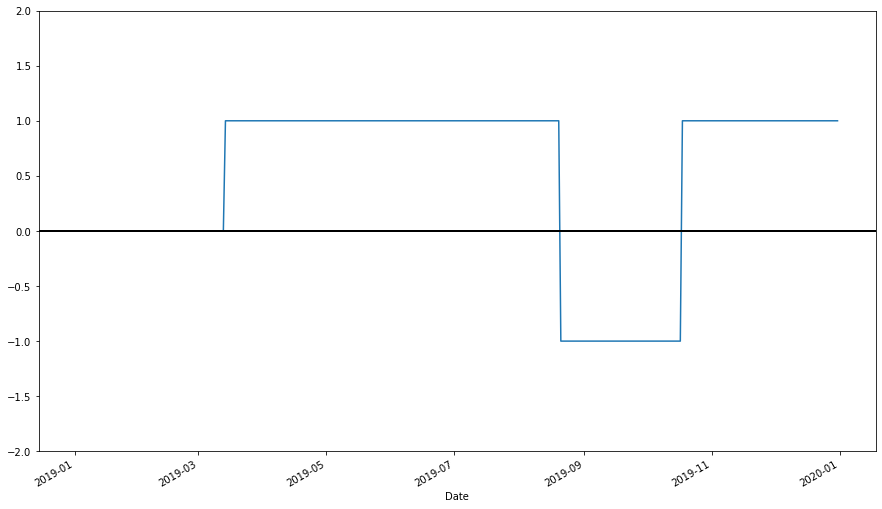

In [90]:
GLOBANT['20d-50d'] = GLOBANT['20d'] - GLOBANT['50d']

# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
GLOBANT["Regime"] = np.where(GLOBANT['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
GLOBANT["Regime"] = np.where(GLOBANT['20d-50d'] < 0, -1, GLOBANT["Regime"])
GLOBANT.loc['2019-01-01':'2019-12-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [92]:
GLOBANT["Regime"].value_counts()

 1    162
 0     49
-1     41
Name: Regime, dtype: int64

Esto indica que el mercado fue 41 días bullish (-1), esto disparó una señal de compra. Y tuvo 162 días bearish regime(1), que esto marca una señal de venta.

In [93]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = GLOBANT.loc[:, "Regime"].iloc[-1]
GLOBANT.loc[:, "Regime"].iloc[-1] = 0
GLOBANT["Signal"] = np.sign(GLOBANT["Regime"] - GLOBANT["Regime"].shift(1))
# Restore original regime data
GLOBANT.loc[:, "Regime"].iloc[-1] = regime_orig
GLOBANT.tail()

/Users/pablotempone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,High,Low,Open,Close,Volume,Adj Close,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,
2019-12-24,108.466003,107.629997,108.389999,108.150002,50900,108.150002,103.61,99.83,93.57,3.78,1,0.0
2019-12-26,110.029999,107.699997,108.050003,109.580002,135500,109.580002,103.70,99.99,93.76,3.71,1,0.0
2019-12-27,110.430000,107.510002,110.070000,107.940002,147700,107.940002,103.71,100.14,93.94,3.57,1,0.0
2019-12-30,107.190002,104.239998,107.190002,106.099998,122400,106.099998,103.66,100.27,94.11,3.39,1,0.0
2019-12-31,106.400002,104.410004,105.730003,106.050003,110000,106.050003,103.78,100.43,94.29,3.35,1,-1.0


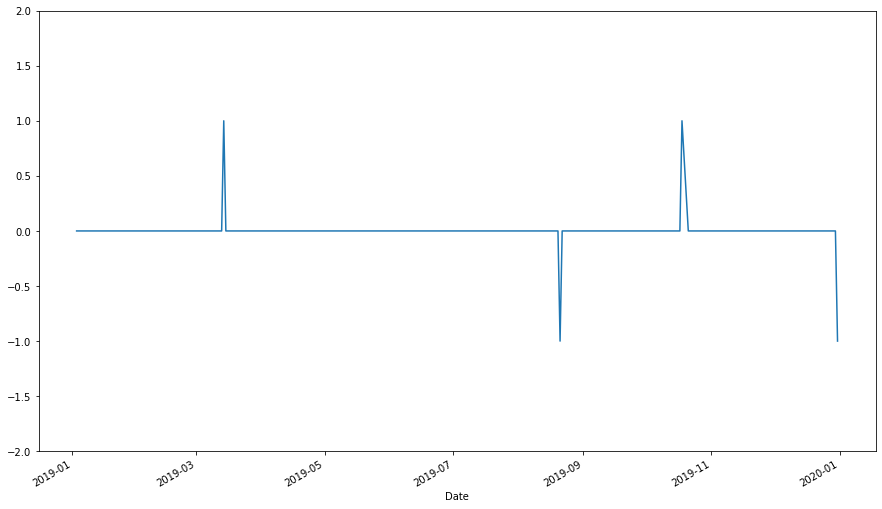

In [94]:
GLOBANT["Signal"].plot(ylim = (-2, 2))

In [95]:
GLOBANT["Signal"].value_counts()

 0.0    247
-1.0      2
 1.0      2
Name: Signal, dtype: int64

Ahora utilizamos las señales de esos cambios de regimen cuando ocurrieron las oportunidades de comprar acciones y cuando de vender. 2 días fue conviniente comprar y 2 días vender.

In [96]:
GLOBANT.loc[GLOBANT["Signal"] == 1, "Close"]

Date
2019-03-14    70.910004
2019-10-18    97.779999
Name: Close, dtype: float64

Esos días fue conveniente comprar acciones.

In [97]:
GLOBANT.loc[GLOBANT["Signal"] == -1, "Close"]

Date
2019-08-21     93.629997
2019-12-31    106.050003
Name: Close, dtype: float64

Esos días convino vender las acciones.

In [99]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
glob_signals = pd.concat([
        pd.DataFrame({"Price": GLOBANT.loc[GLOBANT["Signal"] == 1, "Adj Close"],
                     "Regime": GLOBANT.loc[GLOBANT["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": GLOBANT.loc[GLOBANT["Signal"] == -1, "Adj Close"],
                     "Regime": GLOBANT.loc[GLOBANT["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
glob_signals.sort_index(inplace = True)
glob_signals

,Price,Regime,Signal
Date,,,
2019-03-14,70.910004,1,Buy
2019-08-21,93.629997,-1,Sell
2019-10-18,97.779999,1,Buy
2019-12-31,106.050003,1,Sell


In [101]:
# Let's see the profitability of long trades
glob_long_profits = pd.DataFrame({
        "Price": glob_signals.loc[(glob_signals["Signal"] == "Buy") &
                                  glob_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(glob_signals["Price"] - glob_signals["Price"].shift(1)).loc[
            glob_signals.loc[(glob_signals["Signal"].shift(1) == "Buy") & (glob_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": glob_signals["Price"].loc[
            glob_signals.loc[(glob_signals["Signal"].shift(1) == "Buy") & (glob_signals["Regime"].shift(1) == 1)].index
        ].index
    })
glob_long_profits

,Price,Profit,End Date
Date,,,
2019-03-14,70.910004,22.719994,2019-08-21
2019-10-18,97.779999,8.270004,2019-12-31
